In [2]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

In [10]:
# Emotion kind validation function for RAVDESS database
def find_emotion_R(file): 
    emotion = file[6:8]
    if emotion == '01': return 'neutral'
    elif emotion == '02': return 'calm'
    elif emotion == '03': return 'happy'
    elif emotion == '04': return 'sad'
    else: return 'unknown'

# 'emotions' list fix for classification purposes:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    else:               return -1 # unknown/suprised/none

In [11]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = 'C:/Users/admin/Ravdess'

for subdir, dirs, files in os.walk(folder_path):
    for file in files: 
        x, sr = librosa.load(path = os.path.join(subdir, file), sr = None)
        xt, index = librosa.effects.trim(x, top_db=30)
     
        sample_lengths.append(len(xt))
        
        
print('Maximum sample length:', np.max(sample_lengths))  

Maximum sample length: 204288


In [12]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 204288*2 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = 'C:/Users/admin/Ravdess' 

for subdir, dirs, files in os.walk(folder_path):
    for file in files: 

        # Fetch the sample rate.
        _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
        # Load the audio file.
        rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
        # Normalize the audio to +5.0 dBFS.
        normalizedsound = effects.normalize(rawsound, headroom = 0) 

        # Transform the normalized audio to np.array of samples.
        normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

        # Trim silence from the beginning and the end.
        xt, index = librosa.effects.trim(normal_x, top_db=30)
        #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed-- 

        # Pad for duration equalization.
        padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')

        # Noise reduction.
        final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22
       
        # Features extraction 
        f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
        f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
        f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      
        # Emotion extraction from the RAVDESS database
        name = file[6:8]

        # Filling the data lists  
        rms.append(f1)
        zcr.append(f2)
        mfcc.append(f3)
        emotions.append(emotionfix(name))
        
        
toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 2.5894144 -6.9144917  9.804947  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 2.5894144 -6.9144917  9.804947  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-1.3378583  -0.6495272  -0.23169598 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.49372116  0.51801753 -3.3325698  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ -6.950613 -11.247675   9.863469 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ -6.950613 -11.247675   9.863469 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 5.726671   -0.32456857 -1.1230291  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-211.02303  -138.35248   -50.103626 ...    0.          0.
    0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-211.02303  -138.35248   -50.103626 ...    0.          0.
    0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.featur

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-1.6874022 -5.324998   4.091129  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.5240728  -0.6859751  -0.98003364 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.5240728  -0.6859751  -0.98003364 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.m

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[168.73953     3.7086296  44.797684  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.03505527 -0.59809756 -1.478273   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.03505527 -0.59809756 -1.478273   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.m

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.701401   -0.39811987 -0.20088497 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.701401   -0.39811987 -0.20088497 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.16975439 0.28515667 0.74702394 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.10674584  1.1182598  -1.5131191  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 917.08234  264.41064 -229.73245 ...    0.         0.         0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 917.08234  264.41064 -229.73245 ...    0.         0.         0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.3852427  -0.07752654  0.25682887 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-181.27794 -167.82835  -24.64896 ...    0.         0.         0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-181.27794 -167.82835  -24.64896 ...    0.         0.         0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.10232695 -0.03242198 -0.05278169 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.10232695 -0.03242198 -0.05278169 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.26584437 -2.2671804   0.23178151 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rm

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.05405417 0.4027508  1.879382   ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.6115213   1.091431   -0.76944196 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.6115213   1.091431   -0.76944196 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.m

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[1.8197552 2.0217228 2.3612244 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.4518987  -0.49974597 -0.5122437  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.4518987  -0.49974597 -0.5122437  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(fi

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[5.43363   2.1472971 0.669057  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[5.43363   2.1472971 0.669057  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[4.1130943 3.3137946 4.04499   ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, fram

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-1.9669566 -1.8103197 -0.2478276 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.2601423 1.7966942 2.468306  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[3.2601423 1.7966942 2.468306  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[4.3782754  1.1081369  0.38336855 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.10142382  0.30223638  0.62742734 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.10142382  0.30223638  0.62742734 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.m

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 1.0964885  -0.8252877  -0.19255283 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 1.0964885  -0.8252877  -0.19255283 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[12.934489  -1.0573553 -3.3072255 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.64047897 -0.8689295   0.40942532 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.64047897 -0.8689295   0.40942532 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-28.882298 -85.67526  -48.473736 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[2.18567    2.4342797  0.34724653 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[2.18567    2.4342797  0.34724653 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[4.4738593 5.2700443 4.341326  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 1.823061  -2.3790271 -1.3469484 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 1.823061  -2.3790271 -1.3469484 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.8719733 4.7280583 4.2063828 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.21148813 -0.83460623  0.04818032 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.21148813 -0.83460623  0.04818032 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.43355772 0.24773937 0.31061074 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 1.862791  -4.6552644  3.092033  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.23607242 -1.1432356  -1.399284   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.23607242 -1.1432356  -1.399284   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.m

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.51345044 1.6523758  0.8819347  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-2.5374331  -0.10607863 -1.4850423  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-2.5374331  -0.10607863 -1.4850423  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.m

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[1.5313104  1.1917353  0.02409962 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[1.5313104  1.1917353  0.02409962 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-15.242331    3.9552906 -18.961178  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-24.843718  -8.628254 -11.630033 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-24.843718  -8.628254 -11.630033 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-11.847032 -10.722507   4.276922 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[4.3572235  1.9147627  0.91984123 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[4.3572235  1.9147627  0.91984123 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[2.3903594 2.6219049 1.9882792 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.05668066  7.6747093  -1.2791084  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.05668066  7.6747093  -1.2791084  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-2.3013165 -8.660596  -8.484742  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.27096963  3.3445292   6.3978496  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.27096963  3.3445292   6.3978496  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.16929556 -0.5879936  -0.16183743 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rm

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 1.4235084  -0.22235847  0.14581542 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 1.4235084  -0.22235847  0.14581542 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.5948164 -1.4264978 -1.8564773 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[52.22632 54.06982 67.49383 ...  0.       0.       0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[10.249595  12.297955   2.3259585 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[10.249595  12.297955   2.3259585 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[4.2625256 5.991483  6.219746  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[  9.248505  66.09062  119.55431  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[  9.248505  66.09062  119.55431  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[20.84776   14.7851715 16.52619   ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ -7.4326086 -13.558546   -3.0180964 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ -7.4326086 -13.558546   -3.0180964 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[19.551737 16.880938 20.871609 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[  6.0491066  -3.8423193 -16.014444  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[  6.0491066  -3.8423193 -16.014444  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-13.402493   -7.4708433   4.260856  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-13.402493   -7.4708433   4.260856  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 14.05003    2.870815 -10.806351 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-7.876447    0.22837351  0.88737696 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-7.876447    0.22837351  0.88737696 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[  0.39228037   3.3633015  -20.356537   ...   0.           0.
   0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feat

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-19.985128 -29.911291 -14.616047 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-19.985128 -29.911291 -14.616047 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[6.7186446 4.7841887 1.7161307 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 3.7036612 -3.609646  -4.1487083 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 3.7036612 -3.609646  -4.1487083 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.42062256 -1.1315196  -1.7515424  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[10.854952   7.2635856  4.1609583 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[10.854952   7.2635856  4.1609583 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ -4.2234764  11.085197  -12.206478  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[33.14225  29.110443 33.505028 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[33.14225  29.110443 33.505028 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-45.114017 -36.400845 -39.70691  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 1.2537615  -0.10438541 -1.1493963  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 1.2537615  -0.10438541 -1.1493963  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-10.698179   -4.1319513 -18.864788  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 5.4956837  9.510977  20.527737  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 5.4956837  9.510977  20.527737  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 30.319738 123.74409  189.36797  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-3.9100883  -1.9474341   0.23116723 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[26.73618  17.029617 -5.589473 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[26.73618  17.029617 -5.589473 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 4.850345  -2.1371613 -2.2877016 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 4.850345  -2.1371613 -2.2877016 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[8.544979 7.964319 9.197376 ... 0.       0.       0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-17.412731    5.0894847  -2.9351258 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-17.412731    5.0894847  -2.9351258 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-3.710909   0.832945  -1.3897034 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-4.02284   -3.773484  -3.4301841 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-4.02284   -3.773484  -3.4301841 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-4.0794663  5.3386188 -4.3920684 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-2.5099647 -3.2017477 -3.0084805 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-2.5099647 -3.2017477 -3.0084805 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 65.68335     4.3340673 -34.72799   ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-11.198671    24.690403    -0.44832695 ...   0.           0.
   0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.2759912 0.7957037 6.9839916 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[3.2759912 0.7957037 6.9839916 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.46763    -3.5678434  -0.42490372 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[8.703258 3.726354 8.789862 ... 0.       0.       0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[8.703258 3.726354 8.789862 ... 0.       0.       0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_m

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-46.668526 -21.215847 -11.609391 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.491123   6.0424814 -2.0959406 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.491123   6.0424814 -2.0959406 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 8.591548 20.845915 27.562288 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 8.591548 20.845915 27.562288 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-10.380093    1.7633328  19.485155  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[1.4866834  0.05407169 1.5000935  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-234.8454 -270.2265 -159.6091 ...    0.        0.        0.    ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-234.8454 -270.2265 -159.6091 ...    0.        0.        0.    ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.41560587  0.21785946 -0.7624646  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.41560587  0.21785946 -0.7624646  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[6.480142  3.9289608 1.9396747 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(fin

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[3.206976 5.871804 3.085436 ... 0.       0.       0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-1.0724398 -1.6433055 -3.6340146 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-1.0724398 -1.6433055 -3.6340146 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 1.1234559  3.217219  -7.373133  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 1.1234559  3.217219  -7.373133  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-3.3480637 -4.598878  -3.437658  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ -9.797192 -13.746958 -13.864912 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[23.24402  22.330618 24.30703  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[23.24402  22.330618 24.30703  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[9.825407  9.029732  2.7541049 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[31.871523 12.780892 31.11982  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[31.871523 12.780892 31.11982  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-12.929981 -11.367044 -13.276639 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 6.365776   1.4977039 -2.1949966 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 6.365776   1.4977039 -2.1949966 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[17.876648 15.023548 22.687445 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-2.9860978  3.4249268 -0.6277211 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-2.9860978  3.4249268 -0.6277211 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 1.5940064 -0.3263188 -0.9229805 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 1.5940064 -0.3263188 -0.9229805 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-1.1060956 -1.8855543 -1.4454381 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.05083061 -2.105619    0.7218973  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-4.3687015 -4.374297  -4.54527   ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-4.3687015 -4.374297  -4.54527   ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.68136734 -0.7618224   0.58724636 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 6.6549177   0.24280207 -5.877945   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 6.6549177   0.24280207 -5.877945   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mf

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-32.14754  -56.119705 -90.67567  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[14.221057 16.728214 33.06629  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[14.221057 16.728214 33.06629  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[11.589985  6.304475  8.444649 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[11.589985  6.304475  8.444649 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[7.122948 5.879894 7.397425 ... 0.       0.       0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_leng

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[39.324287 18.829498 37.25955  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[39.324287 18.829498 37.25955  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[1.8019533 4.6400266 1.885246  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, fram

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-2.1058855  -0.04826448  0.05833419 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 8.064539  8.700015 10.494604 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 8.064539  8.700015 10.494604 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-16.514399  -12.021536   -7.5854034 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[6.883734  6.579186  7.2652793 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[6.883734  6.579186  7.2652793 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[16.859892 16.961653 18.759645 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[16.859892 16.961653 18.759645 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[46.438457 42.272717 48.331833 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, fram

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.5481883 3.825657  3.5560892 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.5481883 3.825657  3.5560892 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.42145097 -1.0194138  -0.0275288  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x,

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.57491326 -1.8093247  -1.7623698  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.57491326 -1.8093247  -1.7623698  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-3.3629936e-01 -2.1936053e-01 -9.5732779e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.24603726  0.22689414 -0.03833788 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.24603726  0.22689414 -0.03833788 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-3.9190323  5.209309   9.033872  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.8215507  -0.13808672 -0.02413474 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.8215507  -0.13808672 -0.02413474 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[1.4886566 1.5231807 1.6368852 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(fin

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 182.57297  143.47112 -104.72205 ...    0.         0.         0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-85.32582  -10.667933 -25.366385 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-85.32582  -10.667933 -25.366385 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[17.37442   -1.4953254 -2.2251992 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[17.37442   -1.4953254 -2.2251992 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-26.290722 -42.712254 -14.081401 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.91324383 0.38332573 0.75784695 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.91324383 0.38332573 0.75784695 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.8932908  2.0053623  0.69698703 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-5.75232    -4.64917    -0.34057012 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-5.75232    -4.64917    -0.34057012 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.495651  4.685099  4.7412195 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(fin

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 20.100689  21.828821 -67.04157  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 20.100689  21.828821 -67.04157  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-1.0805284 -0.8099964 -1.1915433 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[157.9863   130.96054   36.245266 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[157.9863   130.96054   36.245266 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.61062044 -0.8723688  -0.9608659  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-20.323536 -20.10723  -16.162558 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-20.323536 -20.10723  -16.162558 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[2.0812507 3.8162065 3.4904015 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-1.850043   4.038984   4.5755935 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-1.850043   4.038984   4.5755935 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[2.1840534 2.404402  2.0352008 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.09478051 0.60674244 0.12021586 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.09478051 0.60674244 0.12021586 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.5229278  0.52007306 0.17715693 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ -3.302095    0.9785125 -24.465626  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ -3.302095    0.9785125 -24.465626  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.11260185 -0.3106418  -0.44839856 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-3.4900217 -3.5157473 -3.4836915 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-3.4900217 -3.5157473 -3.4836915 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.22050552 0.24516645 0.5495325  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.1570482  -0.11565869 -0.00264797 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.1570482  -0.11565869 -0.00264797 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.26302114 -0.05819087  0.20161219 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rm

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[13.440822   2.2245662  6.3582997 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[13.440822   2.2245662  6.3582997 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[11.884442 13.867961 18.80016  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-105.524765  405.38766   -26.732893 ...    0.          0.
    0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-105.524765  405.38766   -26.732893 ...    0.          0.
    0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-1.0305384 -1.5792121 -1.8371003 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.featu

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 3.252955   3.0439043 -1.4607915 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 3.252955   3.0439043 -1.4607915 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-1.6489314 -1.4979712 -2.5615842 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-4.0724382 -4.093601  -3.0170197 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-4.0724382 -4.093601  -3.0170197 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[7.52808   5.315567  3.7416935 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-124.9007   -73.55208  -30.67973 ...    0.         0.         0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-124.9007   -73.55208  -30.67973 ...    0.         0.         0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[25.267271 20.465057 42.333626 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.20499212 -0.8013091  -0.30451673 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.20499212 -0.8013091  -0.30451673 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-25.081196 -21.087154 -25.577557 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 99.7101    39.279785 146.6349   ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 99.7101    39.279785 146.6349   ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-28.085863 -29.375381 -31.044823 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-3.1986241 -0.9195505 -0.7194796 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-3.1986241 -0.9195505 -0.7194796 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-2.596251  -4.567634  -5.0378056 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.6993037 0.719275  0.3900309 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.6993037 0.719275  0.3900309 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[12.194354  13.289225  15.3281355 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.25185272 -0.15812182  0.15386248 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.25185272 -0.15812182  0.15386248 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-31.033386 -29.845116 -32.17341  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[37.936134 20.095236 28.57317  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[37.936134 20.095236 28.57317  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.22230206 -0.9724189   1.2181221  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x,

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-59.914856 -63.964767 -69.18003  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-59.914856 -63.964767 -69.18003  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.3820195 2.5010364 3.2853801 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-33.75054  -31.487944 -33.916565 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-33.75054  -31.487944 -33.916565 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[8.541501 7.794939 9.603393 ... 0.       0.       0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[1.2825893 0.6584691 1.560324  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[1.2825893 0.6584691 1.560324  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-10.115344 -11.166964 -12.560428 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-12.984233 -12.166802 -16.993357 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-12.984233 -12.166802 -16.993357 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[10.6328535 10.295466   8.36511   ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.47419605  1.3402642  -2.013759   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.47419605  1.3402642  -2.013759   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-1.4620754 -1.6597459  0.3539164 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[20.675259 18.052145 17.471416 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[20.675259 18.052145 17.471416 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-7.7581415 -5.0604105 -4.3296733 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.85505295 -5.007377   10.211958   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.85505295 -5.007377   10.211958   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.9182648  2.033351  -6.7481756 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[56.76128   41.283813   8.3177805 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[56.76128   41.283813   8.3177805 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 224.90115   23.33088 -199.8201  ...    0.         0.         0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 2.6664526  7.3697343 -0.8580032 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.84514695 0.765554   0.863928   ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.84514695 0.765554   0.863928   ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-2.111925  -2.2639792 -1.7432574 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-2.111925  -2.2639792 -1.7432574 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-3.3384573 -7.1745453 -6.2855077 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-1.5560367 -0.8203423  0.4147838 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-1.5560367 -0.8203423  0.4147838 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.7622273  2.622312   1.6679928 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-183.26189   -57.65047    88.237465 ...    0.          0.
    0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-183.26189   -57.65047    88.237465 ...    0.          0.
    0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.00246943 -0.07177891 -0.0932806  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.featur

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.16446066  0.44614896 -0.07357459 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-6.5659795 11.505436  -3.763342  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-6.5659795 11.505436  -3.763342  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.9205754 1.2929474 3.0005367 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[3.9205754 1.2929474 3.0005367 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-2.441375  -1.0829619  1.4185914 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.0837948 4.6819477 1.1263816 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[3.0837948 4.6819477 1.1263816 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 5.478199 13.814854 12.88649  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, fram

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.41964382 0.5251961  1.9147445  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.41964382 0.5251961  1.9147445  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-2.9479368 -3.5239205 -1.5258621 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.33079025  0.7197494   1.0873486  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.33079025  0.7197494   1.0873486  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 5.209344   5.2998896 -2.2712479 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[10.234525  8.802294  4.36727  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[10.234525  8.802294  4.36727  ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.15960592 -1.2816619  -0.6454063  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x,

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-47.04043  -25.417673  20.769428 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-47.04043  -25.417673  20.769428 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.5118839  1.7766929  0.8788425 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.32535967 0.29019842 2.0040448  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.32535967 0.29019842 2.0040448  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-1.1833181 -2.0703182 -3.4798334 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.18151245 2.972645   0.15368663 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.03466755  0.05488034 -0.06832044 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.03466755  0.05488034 -0.06832044 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.m

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[2.96375   1.7975335 2.7530606 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.18600275 -0.06881002  0.4546608  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.18600275 -0.06881002  0.4546608  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(fi

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[1.7408239 3.0503306 3.789535  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[1.7408239 3.0503306 3.789535  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.9102979 2.7783148 2.4845705 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, fram

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.5823558 2.287313  4.1659036 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.5823558 2.287313  4.1659036 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.12096269 0.1116295  0.06038551 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.3296769   0.2375916  -0.02504766 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.3296769   0.2375916  -0.02504766 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.5709968 5.1478386 4.595096  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(fin

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.36311483 -2.126898    0.875919   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[ 0.36311483 -2.126898    0.875919   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 1.936546    0.08024854 -0.22684924 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rm

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.4655247  0.40488413 0.573255   ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.4655247  0.40488413 0.573255   ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[ 0.9611907   0.25904986 -0.11931815 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[-0.07031946 -0.02961088  0.03257857 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[-0.07031946 -0.02961088  0.03257857 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[3.5232868 3.9879785 4.679755  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(fin

C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.6638131 0.9425412 1.0390445 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:43: FutureWarning: Pass y=[0.6638131 0.9425412 1.0390445 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_26300\2117129501.py:41: FutureWarning: Pass y=[0.23760405 0.85806113 2.545461   ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

Running time: 5.4926 minutes


In [5]:
import pandas as pd
# Combine the feature lists into a single dataframe
df = pd.DataFrame({'rms': rms, 'zcr': zcr, 'mfcc': mfcc, 'emotions': emotions})

# Save the dataframe to a CSV file
df.to_csv('ravdess_features13.csv', index=False)

In [8]:
import pandas as pd

df = pd.read_csv('ravdess_features13.csv')

# Extract the features into a numpy array
features = df.values

rms = df.iloc[:, 1:2].values
zcr = df.iloc[:, 2:3].values
mfcc = df.iloc[:, 3:].values

In [14]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (1441, 799, 1)
RMS shape: (1441, 799, 1)
MFCCs shape: (1441, 799, 13)


In [15]:


# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')

# Create a list of indices corresponding to the emotions you need
indices = []
for i, emotion in enumerate(Y):
    if emotion in [0, 1, 2, 3]:  # the emotions you need
        indices.append(i)

# Extract the relevant rows from X and Y
X = X[indices]
Y = Y[indices]

In [8]:
Y

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [16]:
Y = Y[Y != -1] # Filter out unknown emotions from 'Y'
Y = np.expand_dims(Y, axis=1)

In [10]:
Y

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
    

In [4]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist() 
x_path = 'C:/Users/admin/Results/LSTM_Rav/13/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path = 'C:/Users/admin/Results/LSTM_Rav/13/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)


NameError: name 'X' is not defined

In [17]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = 'C:/Users/admin/Results/LSTM_Rav/13/X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = 'C:/Users/admin/Results/LSTM_Rav/13/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [13]:
# Find the unique values in y_train and y_val
#unique_labels = np.unique(np.concatenate([y_train, y_val]))

# Print out the unique values
#print(unique_labels)
print(len(X))
print(len(Y))

672
672


In [18]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.2, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.2, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 4, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 4, dtype = 'int8')

In [15]:
y_train_class

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=int8)

In [16]:
y_val_class

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0,

In [17]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))
print(np.shape(y_val))

(537, 799, 15)
(108, 799, 15)
(27, 799, 15)
(108, 1)


In [18]:
# Save x_test, y_test to JSON.

file_path = 'C:/Users/admin/Results/LSTM_Rav/13/x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'C:/Users/admin/Results/LSTM_Rav/13/y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[2], [1], [3], [0], [2], [2], [2], [2], [1], [2], [2], [2], [3], [3], [3], [2], [3], [3], [2], [2], [2], [1], [0], [1], [0], [3], [1]], "dtype": "int8", "shape": [27, 1], "Corder": true}'

In [19]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [20]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(4, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = 'C:/Users/admin/Results/LSTM_Rav/13/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=300, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 799, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 53,764
Trainable params: 53,764
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
24/24 [==============================] - 21s 661ms/step - loss: 1.3867 - categorical_accuracy: 0.2607 - val_loss: 1.3260 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/300
24/24 [==============================] - 15s 617ms/step - loss: 1.3555 - categorical_accuracy: 0.3091 - val_loss: 1.30

24/24 [==============================] - 17s 701ms/step - loss: 1.0086 - categorical_accuracy: 0.5587 - val_loss: 1.3099 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 87/300
24/24 [==============================] - 17s 714ms/step - loss: 0.9935 - categorical_accuracy: 0.5642 - val_loss: 1.2410 - val_categorical_accuracy: 0.4352 - lr: 0.0010
Epoch 88/300
24/24 [==============================] - 19s 801ms/step - loss: 1.0141 - categorical_accuracy: 0.5642 - val_loss: 1.1356 - val_categorical_accuracy: 0.4907 - lr: 0.0010
Epoch 89/300
24/24 [==============================] - 19s 782ms/step - loss: 1.0184 - categorical_accuracy: 0.5326 - val_loss: 1.1529 - val_categorical_accuracy: 0.4352 - lr: 0.0010
Epoch 90/300
24/24 [==============================] - 19s 799ms/step - loss: 1.0069 - categorical_accuracy: 0.5493 - val_loss: 1.1746 - val_categorical_accuracy: 0.5370 - lr: 0.0010
Epoch 91/300
24/24 [==============================] - 19s 778ms/step - loss: 0.9962 - categorical_accur

24/24 [==============================] - 30s 1s/step - loss: 0.8715 - categorical_accuracy: 0.6052 - val_loss: 1.2480 - val_categorical_accuracy: 0.4722 - lr: 0.0010
Epoch 177/300
24/24 [==============================] - 27s 1s/step - loss: 0.8461 - categorical_accuracy: 0.6331 - val_loss: 1.4541 - val_categorical_accuracy: 0.5093 - lr: 0.0010
Epoch 178/300
24/24 [==============================] - 24s 1s/step - loss: 0.8415 - categorical_accuracy: 0.6313 - val_loss: 1.3168 - val_categorical_accuracy: 0.4259 - lr: 0.0010
Epoch 179/300
24/24 [==============================] - 24s 1s/step - loss: 0.9170 - categorical_accuracy: 0.6089 - val_loss: 1.3249 - val_categorical_accuracy: 0.5278 - lr: 0.0010
Epoch 180/300
24/24 [==============================] - 25s 1s/step - loss: 0.9901 - categorical_accuracy: 0.5568 - val_loss: 1.1483 - val_categorical_accuracy: 0.5556 - lr: 0.0010
Epoch 181/300
24/24 [==============================] - 23s 966ms/step - loss: 1.0217 - categorical_accuracy: 0.564

24/24 [==============================] - 32s 1s/step - loss: 0.9098 - categorical_accuracy: 0.6127 - val_loss: 1.3814 - val_categorical_accuracy: 0.4722 - lr: 0.0010
Epoch 267/300
24/24 [==============================] - 30s 1s/step - loss: 0.9635 - categorical_accuracy: 0.6108 - val_loss: 1.2234 - val_categorical_accuracy: 0.5463 - lr: 0.0010
Epoch 268/300
24/24 [==============================] - 27s 1s/step - loss: 0.8435 - categorical_accuracy: 0.6294 - val_loss: 1.2882 - val_categorical_accuracy: 0.5278 - lr: 0.0010
Epoch 269/300
24/24 [==============================] - 30s 1s/step - loss: 0.7825 - categorical_accuracy: 0.6629 - val_loss: 1.4712 - val_categorical_accuracy: 0.4815 - lr: 0.0010
Epoch 270/300
24/24 [==============================] - 26s 1s/step - loss: 0.7848 - categorical_accuracy: 0.6909 - val_loss: 1.2336 - val_categorical_accuracy: 0.5093 - lr: 0.0010
Epoch 271/300
24/24 [==============================] - 27s 1s/step - loss: 0.7797 - categorical_accuracy: 0.6723 -

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

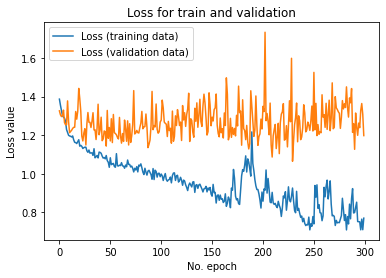

In [22]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

fig1 = plt.gcf()
plt.savefig('C:/Users/admin/Results/LSTM_Rav/13/LossAcc.jpg', dpi=300)
plt.show()


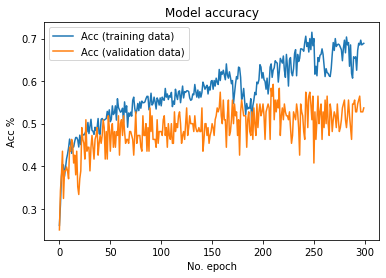

In [23]:
#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

fig2 = plt.gcf()
plt.savefig('C:/Users/admin/Results/LSTM_Rav/13/ModelAcc.jpg', dpi=300)
plt.show()

In [24]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

4/4 - 2s - loss: 1.1962 - categorical_accuracy: 0.5926 - 2s/epoch - 434ms/step


In [25]:
y_val_class

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0,

4/4 [==============================] - 8s 303ms/step


Text(0.5, 51.0, 'Predicted emotion')

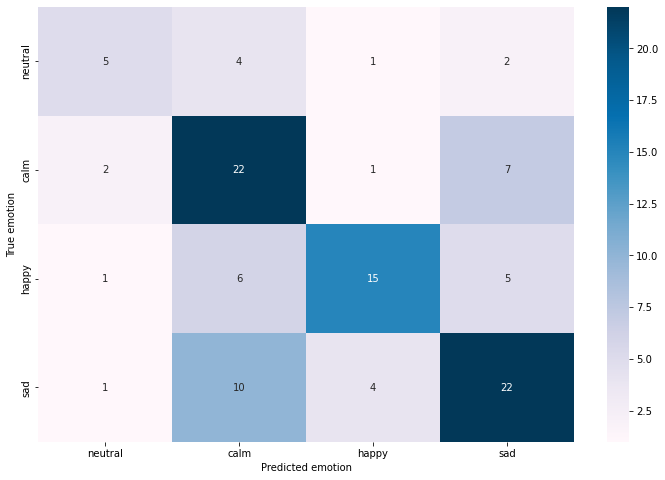

In [26]:
# Validation Confusion matrix
import pandas as pd

# Convert y_val_class into a NumPy array
y_val_class = np.array(y_val_class)

y_val_class = np.argmax(y_val, axis =1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad']  
columns = ['neutral', 'calm','happy', 'sad',]  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [27]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.4167
calm : 0.6875
happy : 0.5556
sad : 0.5946


In [28]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = 'C:/Users/admin/Results/LSTM_Rav/13/model.json'
saved_weights_path = 'C:/Users/admin/Results/LSTM_Rav/13/model_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


In [26]:
# Reading the model from JSON file

saved_model_path = 'C:/Users/admin/Results/LSTM_Rav/13/model.json'
saved_weights_path = 'C:/Users/admin/Results/LSTM_Rav/13/model_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'C:/Users/admin/Results/LSTM_Rav/13/x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('C:/Users/admin/Results/LSTM_Rav/13/y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 4, dtype = 'int8')

In [31]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

1/1 - 6s - loss: 1.1380 - categorical_accuracy: 0.5926 - 6s/epoch - 6s/step


1/1 [==============================] - 4s 4s/step


Text(0.5, 51.0, 'Predicted emotion')

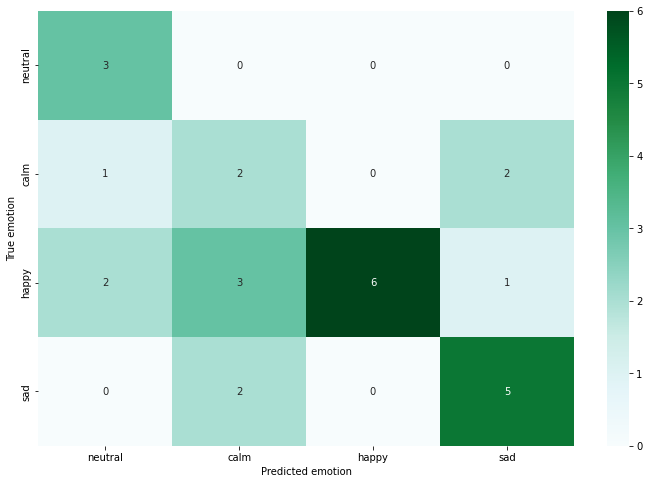

In [32]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad']  
columns = ['neutral', 'calm', 'happy', 'sad']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [33]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 1.0000
calm : 0.4000
happy : 0.5000
sad : 0.7143


In [27]:
from sklearn.metrics import classification_report


predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)
# Calculate per-emotion accuracy and other metrics
report = classification_report(y_test, y_pred_class, target_names=["happy", "sad", "angry", "neutral"], digits=2)
print("\nClassification Report:")
print(report)

1/1 [==============================] - 1s 1s/step

Classification Report:
              precision    recall  f1-score   support

       happy       0.50      1.00      0.67         3
         sad       0.29      0.40      0.33         5
       angry       1.00      0.50      0.67        12
     neutral       0.62      0.71      0.67         7

    accuracy                           0.59        27
   macro avg       0.60      0.65      0.58        27
weighted avg       0.71      0.59      0.60        27

